# Risk-Loss: Scientific Trading Risk Analysis

**Risk-Loss** is a modular, research-grade framework for processing and analyzing real trading activity. It supports structured ingestion of execution logs, trade integrity checks, and generation of risk metrics under controlled assumptions.

* 1. [Project Layout](#project-layout)
* 2. []()

--- 

## Project Layout

```
./
├── pyproject.toml
├── README.md
├── notebooks/
├── input/                  # Drop .xlsx files here
├── output/                 # CSVs, plots, reports
├── src/
│   └── core/
│       ├── pipeline.py     # Load & parse new trades
│       ├── qa.py           # Integrity validation
│       ├── summary.py      # Daily/global risk metrics
│       ├── capital.py      # Capital acquisition logic
│       └── cli.py          # Command-line interface
└── tests/
```

## Installation (editable mode)

```bash
cd ./
pip install -e .
```

## Command-Line Usage

```bash
python src/core/cli.py load --merge --capital 15000
```

Arguments:

* `--merge`: merge fragmented trades
* `--capital`: initial capital (optional; will prompt if missing)

## Processing Pipeline

* Loads new `.xlsx` files from `/input`
* Applies `check_integrity()` to validate structure
* (Optional) Merges split trades
* Computes cumulative equity using initial capital
* Persistence in `output/` as `trades_hist.csv`.
* Additional saving in database (PostgreSQL).
* Prints:

  * Total trades
  * Win-rate
  * Profit Factor
  * Max Drawdown
  * Total PnL
  * Final Equity

## Development Goals

* Add persistent state tracking via SQLite
* Extend CLI with `summary`, `check` subcommands
* Integrate Streamlit for web-based exploration
* Publish as Python package (`risk-loss`)

---

Author: Alex Just Rodríguez
Contact: [alexjustdata@gmail.com](mailto:alexjustdata@gmail.com)


In [2]:
# Paso 1: cargar y preparar el DataFrame desde disco
from core.utils import load_and_prepare_df
df = load_and_prepare_df()  # merge=True, verbose=True por defecto

# Paso 2: exportar el DataFrame como estado global
import types, sys
mod = types.ModuleType("core.global_state")
mod.df = df
sys.modules["core.global_state"] = mod

INFO: 💵 Capital inicial establecido a 419.0$ (persistente en sesión)
INFO: 📦 Total trades cargados: 72
INFO: 💾 Datos guardados en PostgreSQL (trades).
INFO: ✅ Procesados 62 trades en total.


✅ All integrity checks passed
INFO: 🗓 Fecha primer trade: 2025-06-09
INFO: 💵 Capital inicial de la sesión: 419.00$
INFO: 📈 PnL neto del archivo actual: +495.75$
INFO: 💰 Equity final tras cargar: 914.75$


In [5]:
# Importa las funciones necesarias desde el módulo core
from core import daily_summary_from_hist  


# Métricas globales rápidas
df_summary = daily_summary_from_hist(df)

total_fragmented = df["components"].apply(len).gt(1).sum() if "components" in df.columns else 0

print("\nTrades totales :", len(df))
print(f"Número de trades fragmentados: {total_fragmented}")
print("Win-rate       :", (df['pnl_net'] > 0).mean())
print("Profit factor  :", df.loc[df['pnl_net'] > 0, 'pnl_net'].sum() /
                          df.loc[df['pnl_net'] < 0, 'pnl_net'].abs().sum())
print("Drawdown máx % :", 1 - df['equity'].div(df['equity'].cummax()).min())
print("Total PnL_net   :", df['pnl_net'].sum())
print("Última equity   :", df['equity'].iloc[-1])


Trades totales : 58
Número de trades fragmentados: 3
Win-rate       : 0.5862068965517241
Profit factor  : 1.7122844827586208
Drawdown máx % : 0.3617430310797821
Total PnL_net   : 495.75
Última equity   : 914.75


In [6]:
import pandas as pd
from core.merger import explain_fragmented_trade

# Ejemplo para un día concreto con trades fragmentados `fragments_ids`
ids_dia = df_summary.loc[df_summary.day == pd.to_datetime("2025-06-09").date(), "fragmented_ids"].iat[0]

for tid in ids_dia:                     # recorre cada trade-id fragmentado
    for line in explain_fragmented_trade(df, trade_id=tid):
        print(line)
    print()  

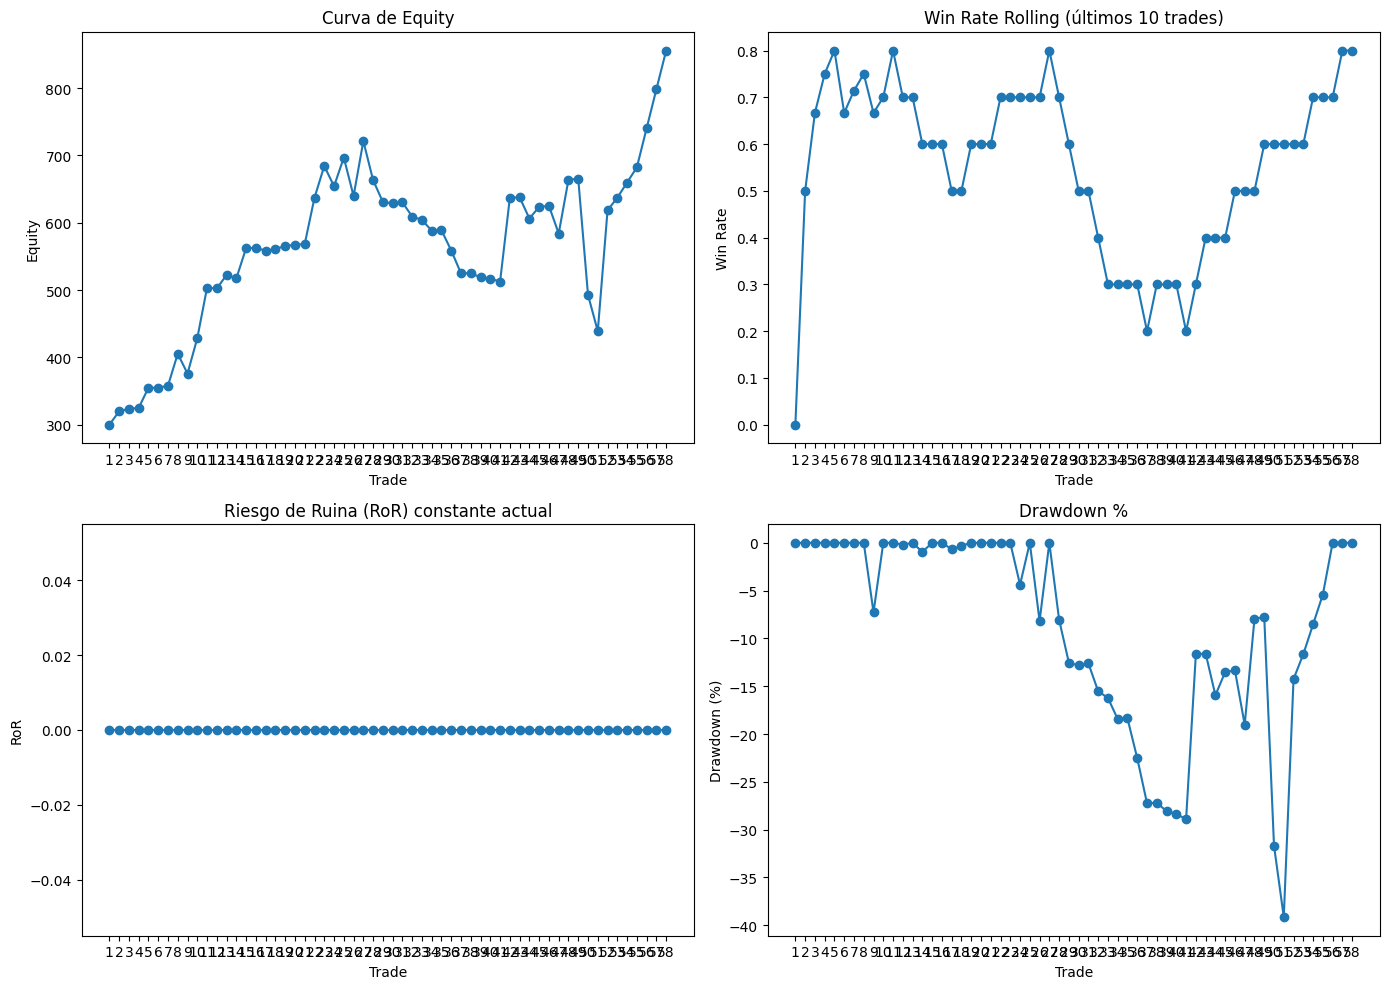

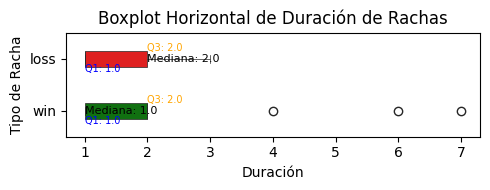


📈 Promedios de Rachas
- Duración promedio de rachas ganadoras: 2.27
- Duración promedio de rachas perdedoras: 1.60



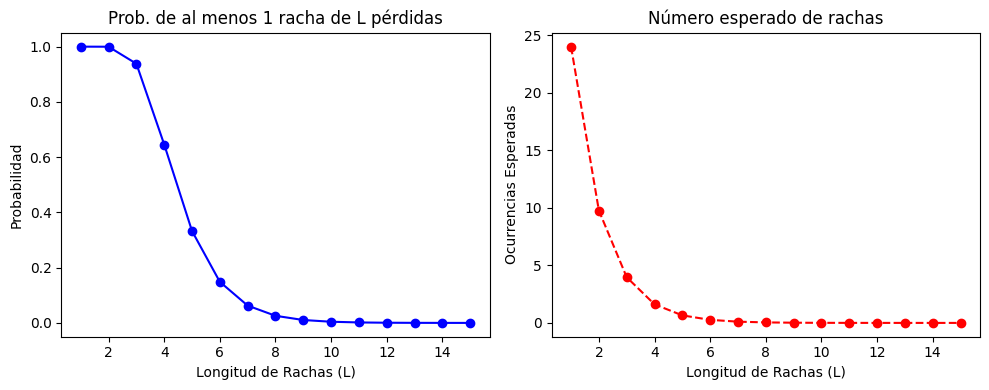


Estadísticas Generales
- Expectancy: 8.55
- Profit Factor: 1.71
- Máximo Drawdown: -39.13%
- Máxima racha de ganancias: 7
- Máxima racha de pérdidas: 3

Intervalo de confianza (95%) para la Expectancy: [-5.87, 21.35]


In [8]:
import importlib, core.statistics
importlib.reload(core.statistics)

from core.statistics import (
    compute_basic_stats,
    print_summary_stats,
    analyze_streaks,
    plot_streak_analysis,
    bootstrap_expectancy_ci
)


# 1. Calcular estadísticas primero
stats = compute_basic_stats(df)

# 2. Análisis de rachas
streak_df = analyze_streaks(win_rate=stats['win_rate'], num_trades=len(df))
plot_streak_analysis(streak_df)

# 3. Mostrar resumen
print_summary_stats(stats)

# 4. Intervalo de confianza para la Expectancy
ci_lower, ci_upper = bootstrap_expectancy_ci(df)
print(f"Intervalo de confianza (95%) para la Expectancy: [{ci_lower:.2f}, {ci_upper:.2f}]")